In [216]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torchvision.transforms import Compose, Resize, ToTensor, CenterCrop

import os
import re
from tqdm import tqdm

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [217]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
device = torch.device(device)
IMG_SIZE = 512
img_dir = "./data/data_0/only_keys_detection"

In [218]:
def mask_to_closest_one_hot(mask, unique_values):
    mask_array = np.array(mask, dtype=np.float32)  # Shape: (IMAGE_SIZE, IMAGE_SIZE)
    mask_tensor = torch.tensor(mask_array).unsqueeze(0)  # Shape: (1, IMAGE_SIZE, IMAGE_SIZE)
    unique_tensor = torch.tensor(unique_values, dtype=torch.float32).view(-1, 1, 1)  # Shape: (3, 1, 1)
    distances = torch.abs(mask_tensor - unique_tensor)  # Shape: (3, IMAGE_SIZE, IMAGE_SIZE)
    closest_indices = torch.argmin(distances, dim=0)  # Shape: (IMAGE_SIZE, IMAGE_SIZE)
    one_hot = torch.nn.functional.one_hot(closest_indices, num_classes=len(unique_values))  # Shape: (IMAGE_SIZE, IMAGE_SIZE, 3)
    one_hot = one_hot.permute(2, 0, 1).float()

    return one_hot

    

In [219]:

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        all_images = os.listdir(root_dir)
        self.images = [img for img in all_images if re.search("Image", img)]
        print(f"Found {len(self.images)} images")
        self.items = []
        loop = tqdm(self.images)
        for img_path in loop:
            image =  Image.open(os.path.join(self.root_dir, img_path)).convert("RGB")
            mask = Image.open(os.path.join(self.root_dir, self._get_mask_for_image(img_path))).convert("L")
            unique_values = np.unique(mask)
            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)
            transform2 = Compose([ToTensor()])
            mask = mask_to_closest_one_hot(mask, unique_values)
            
            image = transform2(image)
            self.items.append((image, mask))


    def __len__(self):
        return len(self.images)

    def _get_mask_for_image(self, img):
        return img.replace("Image", "Segmentation")

    def __getitem__(self, idx):
        return self.items[idx]

In [220]:
transforms = Compose([
    CenterCrop(1080),
    Resize((IMG_SIZE, IMG_SIZE)),
])

In [221]:
def get_images(image_dir, transform = None, batch_size = 1, shuffle = True, pin_memory = True):
    dataset = ImageDataset(image_dir, transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_loader, test_loader

In [222]:
train_loader, test_loader = get_images(img_dir, transforms, batch_size=8)

Found 520 images


100%|██████████| 520/520 [00:41<00:00, 12.44it/s]


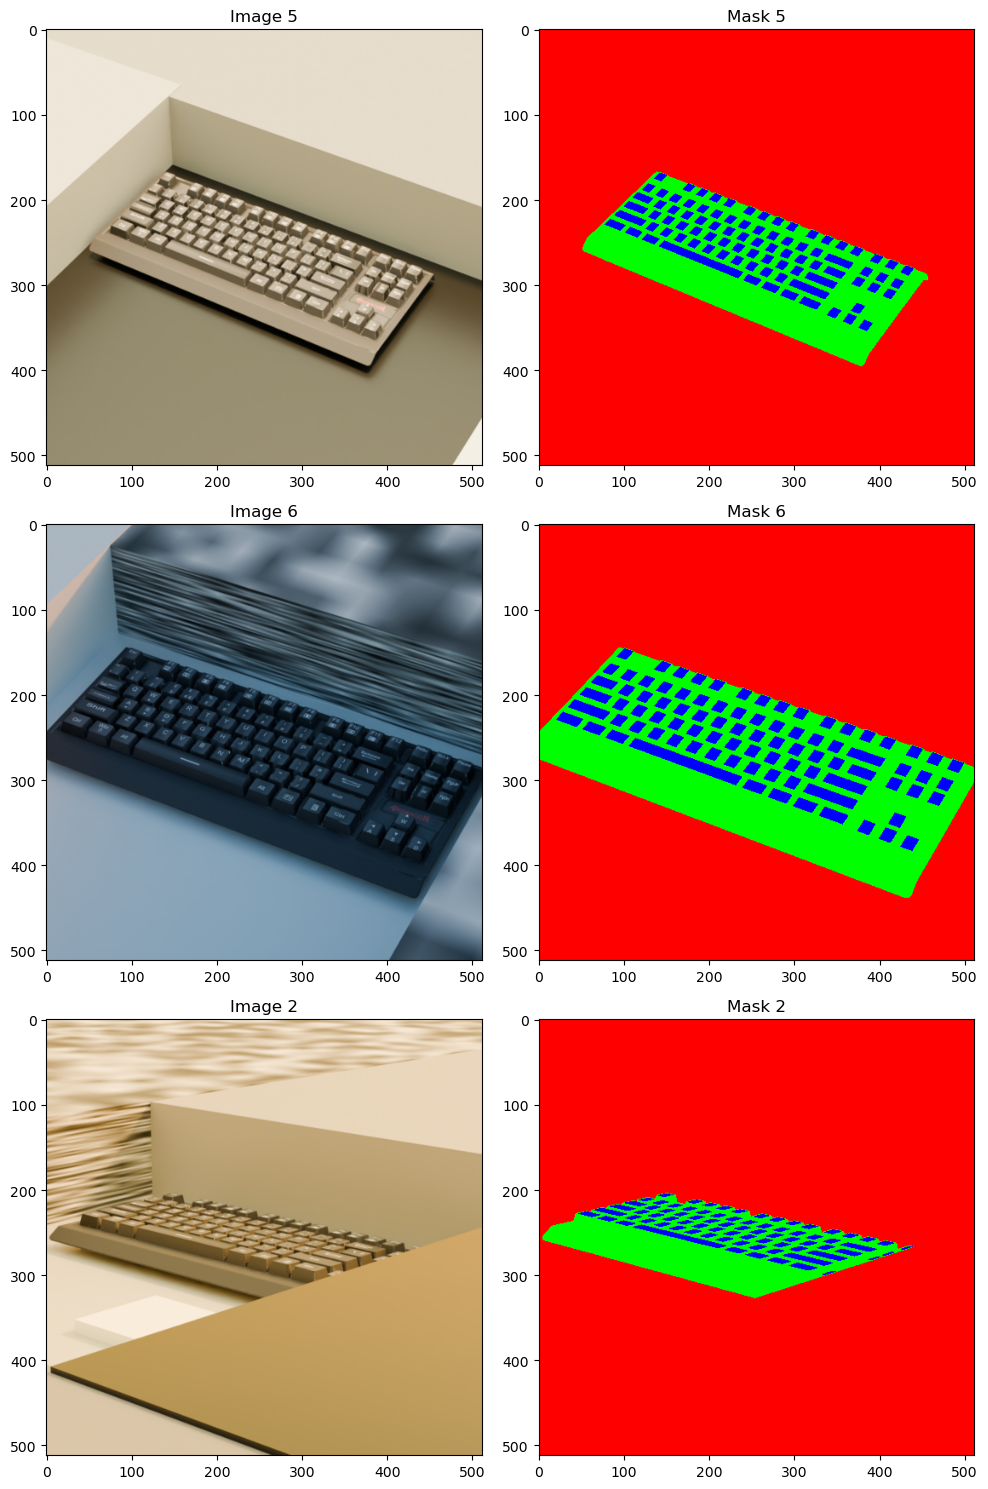

In [223]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

for i, (img, mask) in enumerate(train_loader):
    indices = np.random.choice(img.size(0), 3, replace=False)
    for j, idx in enumerate(indices):
        axes[j, 0].imshow(img[idx].permute(1, 2, 0))
        axes[j, 0].set_title(f'Image {idx}')
        axes[j, 1].imshow(mask[idx].permute(1, 2, 0))
        axes[j, 1].set_title(f'Mask {idx}')
    break

plt.tight_layout()
plt.show()

In [224]:
class RELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch,3,1,1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self,x):
        return self.model(x)

class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        layers = [
            RELUConvBlock(in_ch, out_ch),
            RELUConvBlock(out_ch, out_ch)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self,x):
        return self.model(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        layers = [
            RELUConvBlock(in_ch, out_ch),
            RELUConvBlock(out_ch, out_ch)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self,x):
        return self.model(x)


class UNet(nn.Module):
    def __init__(self, out_ch = 3, down_ch = [64,128,256,512]):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.down0 = DownBlock(3, down_ch[0])
        self.down1 = DownBlock(down_ch[0], down_ch[1])
        self.down2 = DownBlock(down_ch[1], down_ch[2])
        self.down3 = DownBlock(down_ch[2], down_ch[3])

        self.bottleneck = DownBlock(down_ch[3], 2*down_ch[3])

        self.up3 = UpBlock(2*down_ch[-1], down_ch[-1])
        self.up2 = UpBlock(down_ch[-1], down_ch[-2])
        self.up1 = UpBlock(down_ch[-2], down_ch[-3])
        self.up0 = UpBlock(down_ch[-3], down_ch[-4])

        self.connect_b_up3 = nn.ConvTranspose2d(2*down_ch[-1], down_ch[-1],kernel_size=2,stride=2)
        self.connect_up3_up2 = nn.ConvTranspose2d(down_ch[-1], down_ch[-2],kernel_size=2,stride=2)
        self.connect_up2_up1 = nn.ConvTranspose2d(down_ch[-2], down_ch[-3],kernel_size=2,stride=2)
        self.connect_up1_up0 = nn.ConvTranspose2d(down_ch[-3], down_ch[-4],kernel_size=2,stride=2)

        self.final_conv = nn.Conv2d(down_ch[0], out_ch, kernel_size=1)

    def _crop_to_match(self, tensor, target):
        _, _, h, w = target.shape
        return tensor[:, :, :h, :w]

    def forward(self, x):
        skip_connections = []
        x = self.down0(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.down1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.down2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.down3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)

        x = self.connect_b_up3(x)
        skip_connection = self._crop_to_match(skip_connections[3], x)
        x = torch.cat((skip_connection, x), dim=1)
        x = self.up3(x)
        x = self.connect_up3_up2(x)
        skip_connection = self._crop_to_match(skip_connections[2], x)
        x = torch.cat((skip_connection, x), dim=1)
        x = self.up2(x)
        x = self.connect_up2_up1(x)
        skip_connection = self._crop_to_match(skip_connections[1], x)
        x = torch.cat((skip_connection, x), dim=1)
        x = self.up1(x)
        x = self.connect_up1_up0(x)
        skip_connection = self._crop_to_match(skip_connections[0], x)
        x = torch.cat((skip_connection, x), dim=1)
        x = self.up0(x)

        x = self.final_conv(x)

        return x #nn.functional.sigmoid(x)

model = UNet().to(device)
print("Mun params:", sum(p.numel() for p in model.parameters()))
from torchinfo import summary
summary(model, (8, 3, IMG_SIZE, IMG_SIZE))

Mun params: 31043651


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [8, 3, 512, 512]          --
├─DownBlock: 1-1                              [8, 64, 512, 512]         --
│    └─Sequential: 2-1                        [8, 64, 512, 512]         --
│    │    └─RELUConvBlock: 3-1                [8, 64, 512, 512]         1,920
│    │    └─RELUConvBlock: 3-2                [8, 64, 512, 512]         37,056
├─MaxPool2d: 1-2                              [8, 64, 256, 256]         --
├─DownBlock: 1-3                              [8, 128, 256, 256]        --
│    └─Sequential: 2-2                        [8, 128, 256, 256]        --
│    │    └─RELUConvBlock: 3-3                [8, 128, 256, 256]        74,112
│    │    └─RELUConvBlock: 3-4                [8, 128, 256, 256]        147,840
├─MaxPool2d: 1-4                              [8, 128, 128, 128]        --
├─DownBlock: 1-5                              [8, 256, 128, 128]        --
│   

In [225]:
LEARNING_RATE = 1e-4 #na potrzeby testy stały, ale może dodam go w postaci funcji epoki
num_epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler(device)

In [226]:
model.train()
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    for batch_idx, (data, targets) in loop:
        data = data.to(device)
        targets = targets.to(device)
        

        with torch.amp.autocast(device_type=str(device)):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss = loss.item())

100%|██████████| 52/52 [00:17<00:00,  2.96it/s, loss=0.12]  


In [227]:
torch.save(model.state_dict(), "knr_model.pth")

In [228]:
torch.load("knr_model.pth")
torch.cuda.empty_cache()

/tmp/ipykernel_274881/1023012034.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("knr_model.pth")


In [229]:
def check_accuracy(loader, model):
  num_correct, num_pixels, dice_score = 0,0,0
  model.eval()
  with torch.no_grad():
    for dat in loader:
      x,y = dat
      x = x.to(device)
      y = y.to(device)
      y = y.squeeze(1)
      preds = model(x)
      preds = torch.argmax(preds, dim=1)
      corr = torch.argmax(y, dim=1)
      num_correct += (preds == corr).sum().item()
      num_pixels += torch.numel(preds)
      print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")

In [230]:
check_accuracy(train_loader, model)

Got 2035606/2097152 with acc 97.07
Got 4072299/4194304 with acc 97.09
Got 6090163/6291456 with acc 96.80
Got 8110672/8388608 with acc 96.69
Got 10133323/10485760 with acc 96.64
Got 12151429/12582912 with acc 96.57
Got 14179818/14680064 with acc 96.59
Got 16191472/16777216 with acc 96.51
Got 18184518/18874368 with acc 96.35
Got 20199515/20971520 with acc 96.32
Got 22208586/23068672 with acc 96.27
Got 24213705/25165824 with acc 96.22
Got 26249193/27262976 with acc 96.28
Got 28248847/29360128 with acc 96.21
Got 30253522/31457280 with acc 96.17
Got 32264655/33554432 with acc 96.16
Got 34281511/35651584 with acc 96.16
Got 36289748/37748736 with acc 96.14
Got 38313533/39845888 with acc 96.15
Got 40305893/41943040 with acc 96.10
Got 42266737/44040192 with acc 95.97
Got 44310685/46137344 with acc 96.04
Got 46329005/48234496 with acc 96.05
Got 48295607/50331648 with acc 95.95
Got 50286271/52428800 with acc 95.91
Got 52319353/54525952 with acc 95.95
Got 54329205/56623104 with acc 95.95
Got 56345

In [231]:
check_accuracy(test_loader, model)

Got 2045719/2097152 with acc 97.55
Got 4057854/4194304 with acc 96.75
Got 6024062/6291456 with acc 95.75
Got 7992866/8388608 with acc 95.28
Got 9977805/10485760 with acc 95.16
Got 12006424/12582912 with acc 95.42
Got 14033686/14680064 with acc 95.60
Got 15972141/16777216 with acc 95.20
Got 17971239/18874368 with acc 95.22
Got 20007565/20971520 with acc 95.40
Got 22019833/23068672 with acc 95.45
Got 24024815/25165824 with acc 95.47
Got 25933355/27262976 with acc 95.12


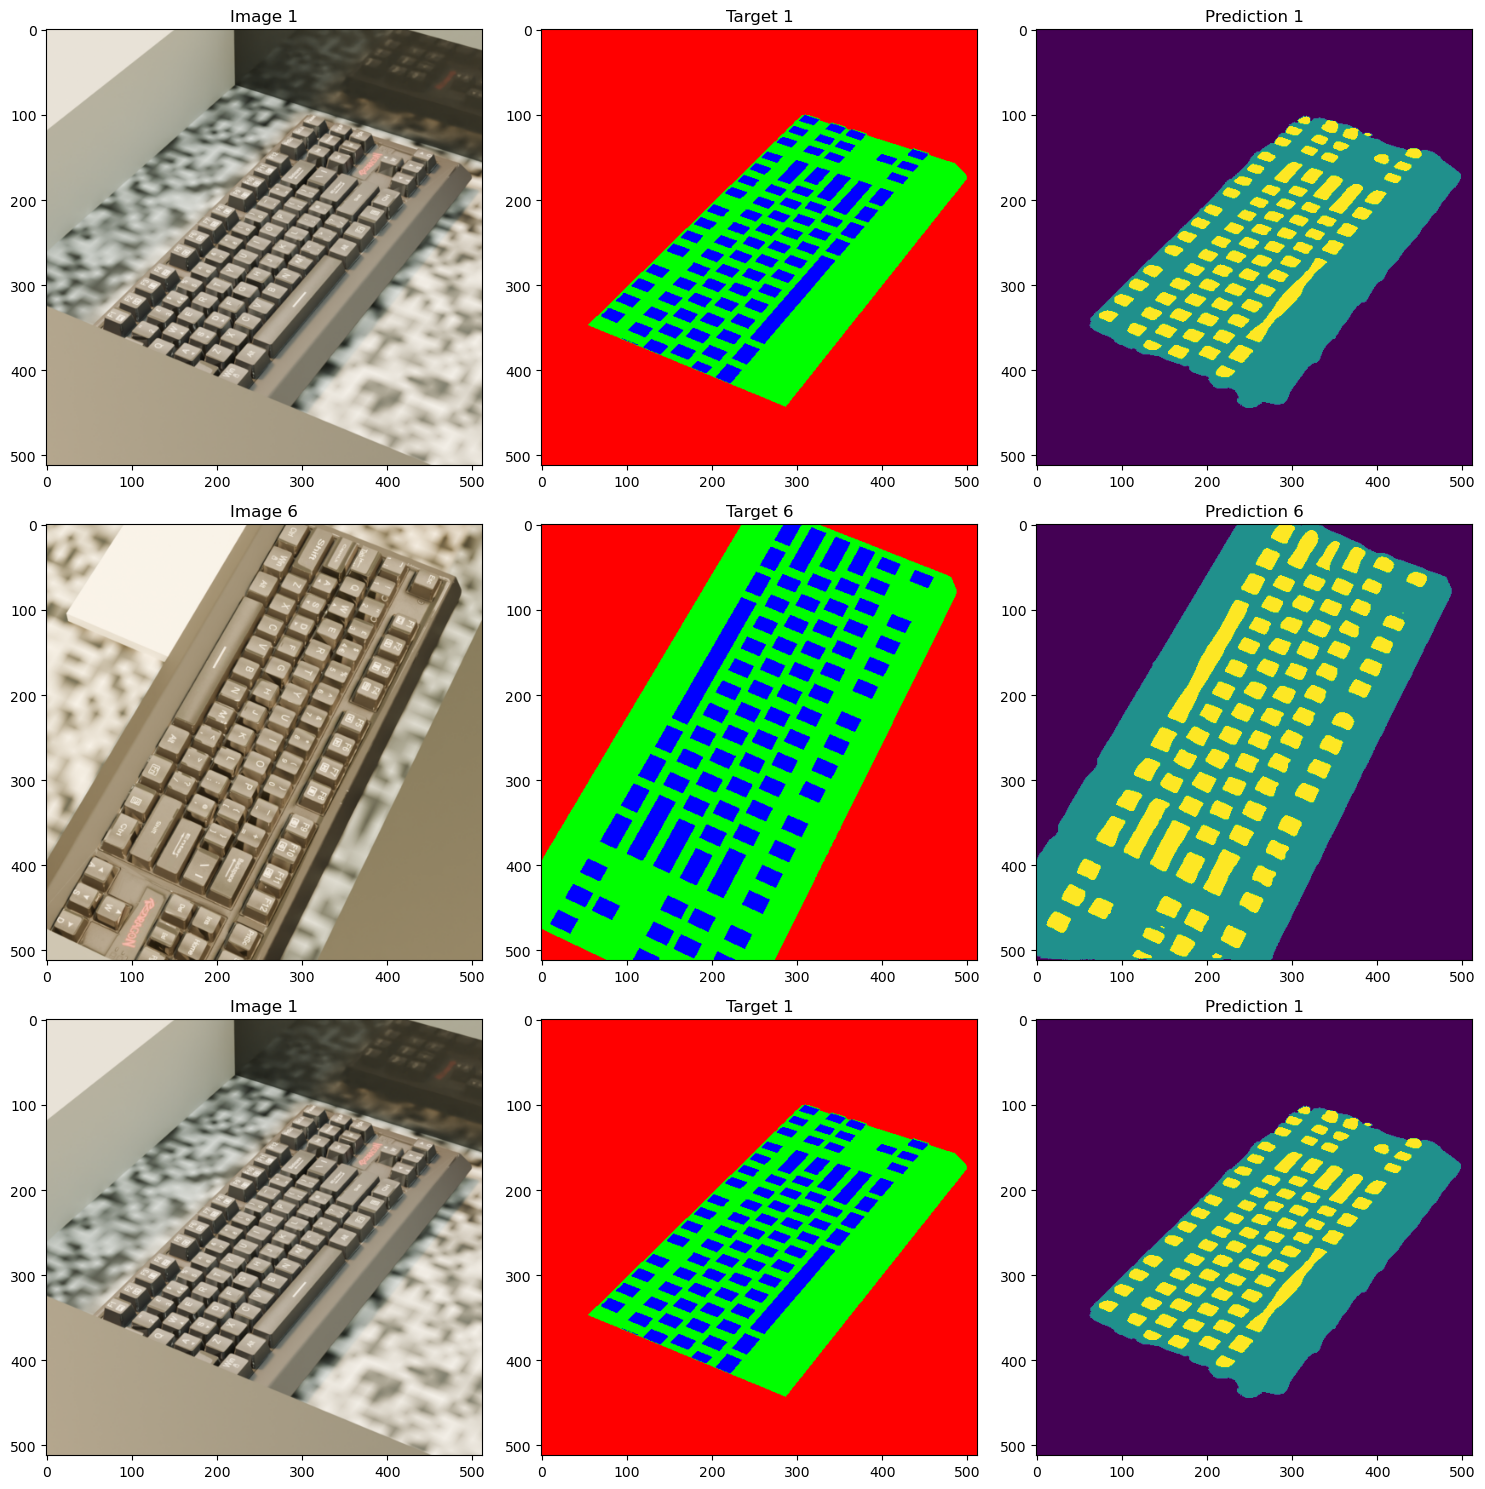

In [232]:
def get_final_mask(preds):
    return torch.argmax(preds, dim=0).numpy()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, dat in enumerate(test_loader):
    with torch.no_grad():
        x, y = dat
        a, b, c = np.random.randint(0, x.size(0), 3)
        x = x.to(device)
        y = y.to(device)
        preds = model(x)
        x = x.cpu()
        y = y.cpu()
        preds = preds.cpu()
        
        for idx, img_idx in enumerate([a, b, c]):
            final_mask = get_final_mask(preds[img_idx])
            axes[idx, 0].imshow(x[img_idx].permute(1, 2, 0))
            axes[idx, 0].set_title(f'Image {img_idx}')
            axes[idx, 1].imshow(y[img_idx].permute(1, 2, 0))
            axes[idx, 1].set_title(f'Target {img_idx}')
            axes[idx, 2].imshow(final_mask)
            axes[idx, 2].set_title(f'Prediction {img_idx}')
        
        break

plt.tight_layout()
plt.show()
    